In [4]:
import sys
sys.path.insert(0, '/home/emmanuel/projects/2020_ml_ocn/ml4ocean/src')

from data.make_dataset import DataLoad

In [267]:
dataloader = DataLoad()

X, y = dataloader.load_control_data('na')

X = X[dataloader.core_vars]
y = np.log(y.drop(dataloader.meta_vars, axis=1))

### Train Testin Split

In [268]:
from sklearn.model_selection import train_test_split

In [269]:
xtrain, xtest, ytrain, ytest = train_test_split(
    X.values, y.values, train_size=0.8, random_state=123
)

### Normalization

In [270]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [272]:
# normalize X
x_scaler = StandardScaler()
xtrain_norm = x_scaler.fit_transform(xtrain)
xtest_norm = x_scaler.transform(xtest)

# decompose Y
n_components = 10
random_state = 123
y_scaler = PCA(n_components=n_components, random_state=random_state)

ytrain_norm = y_scaler.fit_transform(ytrain)
ytest_norm = y_scaler.transform(ytest)

## Baseline ML Models

### Linear Regression

In [273]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

In [274]:
# lin_model = TransformedTargetRegressor(
#     LinearRegression(n_jobs=-1),
#     transformer=y_scaler,
#     check_inverse=False,
# )

lin_model = LinearRegression(n_jobs=-1)


lin_model.fit(xtrain_norm, ytrain);

In [275]:

ypred = lin_model.predict(xtest_norm)

In [276]:
print_stats(ypred, ytest)
# print_stats(ypred, ytest_norm, transformer=y_scaler)

R2: -8.22882335857511
MSE: 0.14375815793165644
MAE: 0.2837539451540763
RMSE: 0.3791545304116205


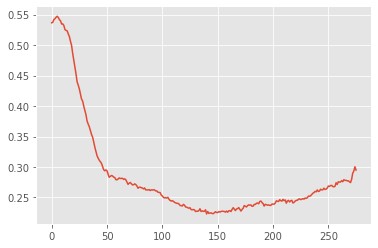

In [277]:
plot_stat_levels(ypred, ytest, stat='mae', )

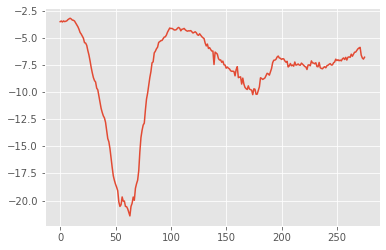

In [278]:
plot_stat_levels(ypred, ytest, stat='r2', )

### Random Forest Regression

In [281]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint

In [ ]:
rf_clf = RandomForestRegressor(n_estimators=100, n_jobs=-1, criterion='mae')

rf_clf.fit(xtrain_norm, ytrain)

In [ ]:
ypred = rf_clf.predict(xtest_norm)

In [ ]:
print_stats(ypred, ytest)

In [ ]:
plot_stat_levels(ypred, ytest, stat='mae')

In [ ]:
plot_stat_levels(ypred, ytest, stat='mse')

In [ ]:
plot_stat_levels(ypred, ytest, stat='r2')

### Cross Validated

In [194]:
# parameter space
n_estimators = [int(x) for x in np.linspace(200, 1000, 10)]
max_features = sp_randint(1, 8)
max_depth = [int(x) for x in np.linspace(10, 110, 11)]
min_samples_split = sp_randint(2, 11)
min_samples_leaf = sp_randint(1, 4)
bootstrap = [True, False]
criterion = ['gini', 'entropy', 'mse']

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [195]:
xtrain_norm.shape

(2417, 8)

In [198]:
rf_clf = RandomForestRegressor()

# grid search params
n_iter = 1_000
cv = 3
verbose = 2
random_state = 123
n_jobs = -1

rf_rand = RandomizedSearchCV(
    estimator=rf_clf, 
    param_distributions=param_grid, 
    n_iter=n_iter, 
    cv=cv, 
    verbose=verbose, 
    random_state=random_state, 
    n_jobs=n_jobs
)

# fit to model
rf_rand.fit(xtrain_norm, ytrain_norm);

rf_rand.best_estimator_

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done 106 tasks      | elapsed:   27.1s
/home/emmanuel/.conda/envs/ml4ocn/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 309 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 592 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 957 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1402 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1929 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 2536 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 13.5min finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=100,
                      max_features=1, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=644,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [199]:
ypred = rf_rand.predict(xtest_norm)

In [92]:
ypred = rf_clf.predict(xtest_norm)

In [93]:
ypred.shape, ytest_norm.shape

((605, 10), (605, 10))

In [200]:
print_stats(ypred, ytest_norm)

R2: -9.242152392080005
MSE: 3.915759598875972e-06
MAE: 0.0009622053611490738
RMSE: 0.0019788278345717627


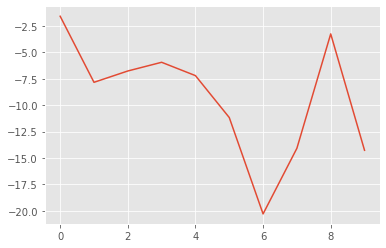

In [201]:
plot_stat_levels(ypred, ytest_norm)

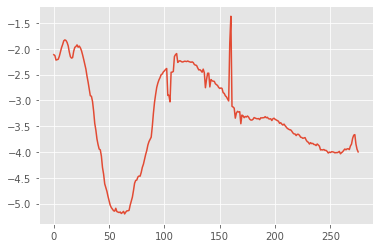

In [202]:
plot_stat_levels(ypred, ytest_norm, stat='r2', transformer=y_scaler)

### Statistics

In [145]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def get_ml_stats(ypred, ytest, stat='r2', output='avg'):
    
    # each sample or average
    if output == 'avg':
        multioutput = 'uniform_average'
    elif output == 'raw':
        multioutput = 'raw_values'
    elif output == 'var':
        multioutput = 'variance_weighted'
    else:
        raise ValueError(f"Unrecognized output param: {output}")
    
    if stat == 'r2':
        res = r2_score(ypred, ytest, multioutput=multioutput)
    elif stat == 'mse':
        res = mean_squared_error(ypred, ytest, multioutput=multioutput)
    elif stat == 'mae':
        res = mean_absolute_error(ypred, ytest, multioutput=multioutput)
    elif stat == 'rmse':
        res = mean_squared_error(ypred, ytest, multioutput=multioutput)
        res = np.sqrt(res)
    else:
        raise ValueError(f"Unrecognized stat param: {stat}")
    
    return res 
    

def print_stats(ypred, ytest, transformer=None):
    if transformer is not None:
        ypred = transformer.inverse_transform(ypred)
        ytest = transformer.inverse_transform(ytest)
    
    for istat in ['r2', 'mse', 'mae', 'rmse']:
        
        print(f"{istat.upper()}: {get_ml_stats(ypred, ytest, stat=istat, output='avg')}")

In [134]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_stat_levels(ypred, ytest, stat='r2', transformer=None):
    
    if transformer is not None:
        ypred = transformer.inverse_transform(ypred)
        ytest = transformer.inverse_transform(ytest)
        
    res = get_ml_stats(ypred, ytest, stat=stat, output='raw')
    
    fig, ax = plt.subplots()
    ax.plot(res)
    plt.show()

### CatBoost

In [166]:
# !pip install catboost

In [167]:
from catboost import CatBoostRegressor, Pool, cv

In [169]:
cat_clf = CatBoostRegressor(
    random_seed=123,
    logging_level='Silent',
)

In [170]:
cat_clf.fit(
    xtrain_norm, ytrain_norm,
    eval_set=(xtest_norm, ytest_norm)
)

CatBoostError: Input label cannot have multiple values per row.